# Converging Speed using the Weigthed Stategy on Models with Increasing Variance

In [1]:
%matplotlib inline

import numpy as np

import math as math

from matplotlib import pyplot as plt

In [2]:
### To solve memory leak issues.

from keras.backend.tensorflow_backend import set_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import get_session
import tensorflow

# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    try:
        del classifier # this is from global space - change this as you need
    except:
        pass

    #print(gc.collect()) # if it's done something you should see a number being outputted

    # use the same config as you used to create the session
    config = tensorflow.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tensorflow.Session(config=config))

Using TensorFlow backend.


### Importing the  data set

In [3]:
from keras.datasets import mnist

(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

In [4]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

### Obtaining the validation set

In [5]:
np.random.seed(5152019)
sample_indexes = np.random.choice(range(len(X_train)), 48000, replace=False)

In [6]:
select = np.in1d(range(X_train.shape[0]), sample_indexes)

In [7]:
X_valid = X_train[~select]
Y_valid = Y_train[~select]
X_train = X_train[select]
Y_train = Y_train[select]

Saving the data.

In [8]:
trainYs = Y_train
validYs = Y_valid
testYs = Y_test

#### Binaryzing the data

In [9]:
X_train = X_train >= 0.5
X_test = X_test >= 0.5
X_valid = X_valid >= 0.5

X_train = X_train.astype('int')
X_test = X_test.astype('int')

### Importing the BDM module

In [10]:
from BDM import calculate_bdm,build_lookup_table

table = build_lookup_table('K-4x4.json')

## Training the models

In [11]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, Flatten,MaxPooling2D
from keras.utils import np_utils
from keras import optimizers

In [12]:
#X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
#X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

Y_train = np_utils.to_categorical(Y_train, 10)
Y_test = np_utils.to_categorical(Y_test, 10)
Y_valid = np_utils.to_categorical(Y_valid, 10)

#Standardization
#mean_px = X_train.mean().astype(np.float32)
#std_px = X_train.std().astype(np.float32)
#X_train = (X_train - mean_px)/(std_px)

## Main Experiment Function

The following function is designed to iterate on several experiments easilly. Also, it allows to control the batch size by using the variable *batchSize*, specified in decimal fractions, while reporting the accuracy of the model after training on **each** batch.

In [13]:
## x and y correspond to the training data.
## xv and yv correspond to the validation data.
## xt and yt correspond to the test data.
def simpleModelResult(
        x = X_train, y = Y_train,
        sample_weight=None,
        layers = 1, epochs = 10,
        xv = X_valid, yv = Y_valid,
        xt = X_test, yt = Y_test,
        batchSize = 1):   
    
    def f(s_weight,batch):
        if(np.any(sample_weight == None)) :
            return None
        return s_weight[batch]
    ### To avoid memory leaks.
    reset_keras()

    model = Sequential()

    model.add(Flatten())
    
    
    for i in range(layers):

        model.add(Dense(128, activation='relu',
                kernel_initializer='random_uniform'))

    model.add(Dense(10, activation='softmax',
                 kernel_initializer='random_uniform'))

    model.compile(loss='categorical_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])

    #history=model.fit(X_train, Y_train, 
    #      batch_size=32, epochs=epochs, verbose=verbose,
    #      validation_data = (X_test, Y_test))
    
    # dictionary with the results
    
    hist = {'acc':np.array([]),
            'loss':np.array([]),
            'test_acc':np.array([]),
            'test_loss':np.array([]),
            'val_acc':np.array([]),
            'val_loss':np.array([])}
    
    # Training the model.
    samples = x.shape[0]
    
    step = math.trunc(samples*batchSize)
    
    total = step*math.trunc(samples/step)
    
    rest = samples - total
    
    for i in range(epochs):
        indx = np.random.permutation(samples)
        
        for j in range(0,total,step):
            batch = indx[j:(j+step)]
            
            _ = np.array(model.train_on_batch(x[batch], y[batch], 
                                  sample_weight=f(sample_weight,batch), 
                                  class_weight=None))
            
            ## To make sure to only evaluate
            ## at the end of the model.           
            res = np.array(model.evaluate(x[batch], y[batch], verbose = 0))
            
            loss = res[list(range(0,len(res),2))]
            acc = res[list(range(1,len(res),2))]
            
            hist['loss'] = np.append(
                hist['loss'],
                np.array(loss))
            
            hist['acc'] = np.append(
                hist['acc'],
                np.array(acc))
            
            ## On validation data
            
            res = np.array(model.evaluate(xv, yv, verbose = 0))
        
            loss = res[list(range(0,len(res),2))]
            acc = res[list(range(1,len(res),2))]
            
            hist['val_loss'] = np.append(
                hist['val_loss'],
                np.array(loss))
            
            hist['val_acc'] = np.append(
                hist['val_acc'],
                np.array(acc))
            
            ## On test data
            
            res = np.array(model.evaluate(xt, yt, verbose = 0))
            
            loss = res[list(range(0,len(res),2))]
            acc = res[list(range(1,len(res),2))]
            
            hist['test_loss'] = np.append(
                hist['test_loss'],
                np.array(loss))
            
            hist['test_acc'] = np.append(
                hist['test_acc'],
                np.array(acc))
            
        if((j+step)<samples):
            batch = indx[(j+step):samples]
            _ = model.train_on_batch(x[batch], y[batch], 
                                  sample_weight=f(sample_weight,batch), 
                                  class_weight=None)
            
            ## To make sure to only evaluate
            ## at the end of the model.           
            res = np.array(model.evaluate(x[batch], y[batch], verbose = 0))
            
            loss = res[list(range(0,len(res),2))]
            acc = res[list(range(1,len(res),2))]
            
            hist['loss'] = np.append(
                hist['loss'],
                np.array(loss))
            
            hist['acc'] = np.append(
                hist['acc'],
                np.array(acc))

            res = np.array(model.evaluate(xv, yv, verbose = 0))
        
            loss = res[list(range(0,len(res),2))]
            acc = res[list(range(1,len(res),2))]
            
            hist['val_loss'] = np.append(
                hist['val_loss'],
                np.array(loss))
            
            hist['val_acc'] = np.append(
                hist['val_acc'],
                np.array(acc))
    
            ## On test data
            
            res = np.array(model.evaluate(xt, yt, verbose = 0))
                           
            loss = res[list(range(0,len(res),2))]
            acc = res[list(range(1,len(res),2))]
            
            hist['test_loss'] = np.append(
                hist['test_loss'],
                np.array(loss))
            
            hist['test_acc'] = np.append(
                hist['test_acc'],
                np.array(acc))
            
    
    return hist


##  Salting the Data Set

In [14]:
## Randomly permutes 'shifts' number of bits of on
## a tensor.
def salt (tensor, shifts=10) :
    shp = tensor.shape # Shape of the tensor
    flatt = tensor.flatten()
    bits = flatt.shape[0]
    indx = np.random.permutation(bits)[:shifts]
    
    for i in indx :
        if flatt[i] == 0 :
            flatt[i] = 1
        else : 
            flatt[i] = 0

    
    flatt = flatt.reshape(shp)
    
    return flatt

In [15]:
## Randomly 'salts' a percentage of the tensor.
def saltP(tensor, percnt = 0.10) :
    bits = int(tensor.size*percnt)
    return salt(tensor, bits)

#### Salting the train set.

First we will randomly choose the samples to be salted. We will salt 40% of data by corrupting 30% of their pixels.

In [16]:
np.random.seed(5152019)

nSalted = int(X_train.shape[0]*0.40) ## Number of tensors to be salted.


## Index of tensors to be salted.
sltIndx = np.random.permutation(X_train.shape[0])[:nSalted]

In [17]:
X_trainS = np.copy(X_train)

In [18]:
np.random.seed(2152019)

for i in sltIndx :
    X_trainS[i] = saltP(X_trainS[i], percnt = 0.30)

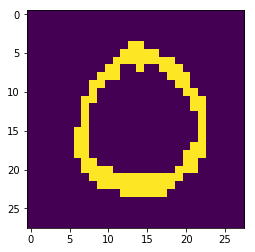

In [19]:
plt.imshow(X_train[sltIndx[0]])

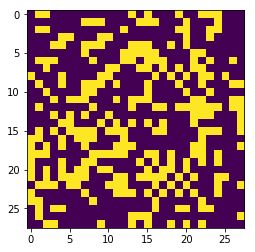

In [20]:
plt.imshow(X_trainS[sltIndx[0]])

#### Salting the test set

In [21]:
X_testS = np.copy(X_test)

In [22]:
np.random.seed(5152019)

nSalted = int(X_test.shape[0]*0.40) ## Number of tensors to be salted.


## Index of tensors to be salted.
sltIndx = np.random.permutation(X_test.shape[0])[:nSalted]

In [23]:
np.random.seed(2152019)

for i in sltIndx :
    X_testS[i] = saltP(X_testS[i], percnt = 0.30)

#### Salting the validation set

In [24]:
X_validS = np.copy(X_valid)

In [25]:
np.random.seed(13122018)

nSalted = int(X_valid.shape[0]*0.40) ## Number of tensors to be salted.


## Index of tensors to be salted.
sltIndx = np.random.permutation(X_valid.shape[0])[:nSalted]

In [26]:
np.random.seed(13122018)

for i in sltIndx :
    X_validS[i] = saltP(X_validS[i], percnt = 0.30)

## Computing the BDM weights

In [27]:
trainSize = X_trainS.shape[0]

In [28]:
bdms = np.zeros(trainSize)

for i in range(trainSize):
    bdms[i] = calculate_bdm(
      X_trainS[i],
            table
    )

In [29]:
values =  {
    0:{
        'min' : np.amin(bdms[trainYs==0]), 
        'max' : np.amax(bdms[trainYs==0]), 
        'mean' : np.mean(bdms[trainYs==0])
        }, 
    1:{
        'min' : np.amin(bdms[trainYs==1]), 
        'max' : np.amax(bdms[trainYs==1]), 
        'mean' : np.mean(bdms[trainYs==1])
        },  
    2:{
        'min' : np.amin(bdms[trainYs==2]), 
        'max' : np.amax(bdms[trainYs==2]), 
        'mean' : np.mean(bdms[trainYs==2])
        }, 
    3:{
        'min' : np.amin(bdms[trainYs==3]), 
        'max' : np.amax(bdms[trainYs==3]), 
        'mean' : np.mean(bdms[trainYs==3])
        }, 
    4:{
        'min' : np.amin(bdms[trainYs==4]), 
        'max' : np.amax(bdms[trainYs==4]), 
        'mean' : np.mean(bdms[trainYs==4])
        },  
    5:{
        'min' : np.amin(bdms[trainYs==5]), 
        'max' : np.amax(bdms[trainYs==5]), 
        'mean' : np.mean(bdms[trainYs==5])
        }, 
    6:{
        'min' : np.amin(bdms[trainYs==6]), 
        'max' : np.amax(bdms[trainYs==6]), 
        'mean' : np.mean(bdms[trainYs==6])
        },  
    7:{
        'min' : np.amin(bdms[trainYs==7]), 
        'max' : np.amax(bdms[trainYs==7]), 
        'mean' : np.mean(bdms[trainYs==7])
        }, 
    8:{
        'min' : np.amin(bdms[trainYs==8]), 
        'max' : np.amax(bdms[trainYs==8]), 
        'mean' : np.mean(bdms[trainYs==8])
        }, 
    9:{
        'min' : np.amin(bdms[trainYs==9]), 
        'max' : np.amax(bdms[trainYs==9]), 
        'mean' : np.mean(bdms[trainYs==9])
        }, 
          }

In [30]:
bdmsPar = np.zeros(trainSize)
j = 0
for i in bdmsPar :
    # bdmsPar[j] = (np.abs(values[trainYs[j]]['mean']-bdms[j]))/(values[trainYs[j]]['mean'])
    #'''
    if bdms[j] > np.percentile(bdms[trainYs==trainYs[j]], 75) :
        bdmsPar[j] = 0.01   
    elif bdms[j] >  np.percentile(bdms[trainYs==trainYs[j]], 50) :
        bdmsPar[j] = 0.5
    else :
        bdmsPar[j] = 2
    #'''
    
    j = j + 1

In [31]:
bdmsPar

array([2.  , 0.5 , 2.  , ..., 2.  , 2.  , 0.01])

# First experiment: Weighted vs Unweighted on the *salted* Data Set

For the next series of experiments, we will train 10 deep learning models with increasing variance. The models consist in a flatten layer, followed by a variable number of fully connected linear layers with rectilinear activation functions, ending with a softmax layer for classification.

All modells were trained for 20 epochs with a batch size of half of the training set. The accuracy is measured **after training on each batch**. 

In [32]:
batchSize = 0.5 

epochs = 40

seed = 12122018

## Depth 1:

In [33]:
np.random.seed(seed)

first = simpleModelResult(
        x = X_trainS, y = Y_train,
        sample_weight=None,
        layers = 1, epochs = epochs,
        xv = X_validS, yv = Y_valid,
        xt = X_test, yt = Y_test,
        batchSize = batchSize)

In [34]:
np.random.seed(seed)
    
firstW = simpleModelResult(
        x = X_trainS, y = Y_train,
        sample_weight=bdmsPar,
        layers = 1, epochs = epochs,
        xv = X_validS, yv = Y_valid,
        xt = X_test, yt = Y_test,
        batchSize = batchSize)

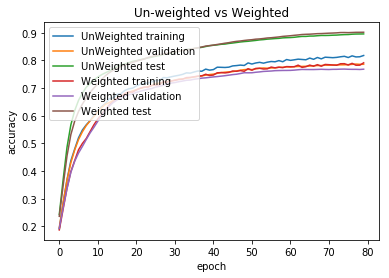

In [35]:
plt.plot(first['acc'])
plt.plot(first['val_acc'])
plt.plot(first['test_acc'])
plt.plot(firstW['acc'])
plt.plot(firstW['val_acc'])
plt.plot(firstW['test_acc'])
plt.title('Un-weighted vs Weighted')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['UnWeighted training', 
            'UnWeighted validation',
            'UnWeighted test',
            'Weighted training', 
            'Weighted validation',
            'Weighted test'], 
           loc='upper left')
plt.show()

At low variance, the accuracy of the models show little difference.

We will now use a simple linear regression using ordinary least square to estimate the convergence speed of the model.

In [36]:
import statsmodels.api as sm

# Returns the slope of a simple linear regression.
def slope (data):
    x = np.array(range(data.size))
    x = sm.add_constant(x)
    return sm.OLS(data, x).fit().params[1]
    

In [37]:
slope(first['val_acc'])

0.0037737537115174217

In [38]:
slope(firstW['val_acc'])

0.003928413619315514

As we can see, the slope of the linear model is slightly flatter for the weighted model, which means that converges slightly faster, but the difference is not significant enough.

### Loss

The loss functions are harder to compare, given that the weighting changes the *scale* of the function itself. However, we can compare again the slopes.

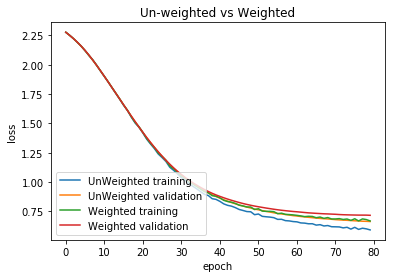

In [39]:
plt.plot(first['loss'])
plt.plot(first['val_loss'])
plt.plot(firstW['loss'])
plt.plot(firstW['val_loss'])
plt.title('Un-weighted vs Weighted')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['UnWeighted training', 'UnWeighted validation','Weighted training', 'Weighted validation'], 
           loc='lower left')
plt.show()

Again, at low variance, the differences seem to be not significant enough. Lets compute this with the slope of the linear approximation on the loss **over the test set**.

In [40]:
slope(first['val_loss'])

-0.020032047656969296

In [41]:
slope(firstW['val_loss'])

-0.019285307291895273

## Depth 2:

Now, we increase the variance of the model by adding a ReLU layer.

In [42]:
np.random.seed(seed)

second = simpleModelResult(
        x = X_trainS, y = Y_train,
        sample_weight=None,
        layers = 2, epochs = epochs,
        xv = X_validS, yv = Y_valid,
        xt = X_test, yt = Y_test,
        batchSize = batchSize)

np.random.seed(seed)
    
secondW = simpleModelResult(
        x = X_trainS, y = Y_train,
        sample_weight=bdmsPar,
        layers = 2, epochs = epochs,
        xv = X_validS, yv = Y_valid,
        xt = X_test, yt = Y_test,
        batchSize = batchSize)

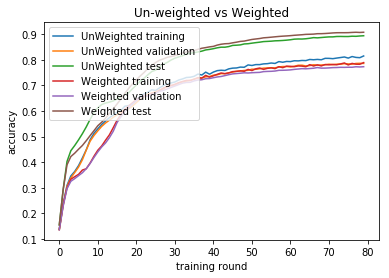

In [43]:
plt.plot(second['acc'])
plt.plot(second['val_acc'])
plt.plot(second['test_acc'])
plt.plot(secondW['acc'])
plt.plot(secondW['val_acc'])
plt.plot(secondW['test_acc'])
plt.title('Un-weighted vs Weighted')
plt.ylabel('accuracy')
plt.xlabel('training round')
plt.legend(['UnWeighted training', 
            'UnWeighted validation',
            'UnWeighted test',
            'Weighted training', 
            'Weighted validation',
            'Weighted test'], 
           loc='upper left')
plt.show()

As expected, the differences increase with variance. We see an advantage for the unweighted model at the 10 first epochs, but this advantage disappears and looks to be inverted after that.t. 

### Loss

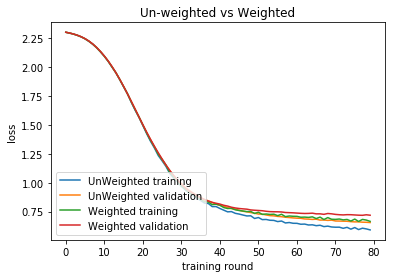

In [44]:
plt.plot(second['loss'])
plt.plot(second['val_loss'])
plt.plot(secondW['loss'])
plt.plot(secondW['val_loss'])
plt.title('Un-weighted vs Weighted')
plt.ylabel('loss')
plt.xlabel('training round')
plt.legend(['UnWeighted training', 'UnWeighted validation','Weighted training', 'Weighted validation'], 
           loc='lower left')
plt.show()

The difference again seem to be small, but we see that the optimization of the loss function start to be steeper on with the weighted model. This is more evident in the test set.

In [45]:
slope(second['val_loss'])

-0.022043328520996087

In [46]:
slope(secondW['val_loss'])

-0.021129539050303663

## Depth 3

We further increase the variance of the model by adding another ReLU layer.

In [47]:
np.random.seed(seed)

third = simpleModelResult(
        x = X_trainS, y = Y_train,
        sample_weight=None,
        layers = 3, epochs = epochs,
        xv = X_validS, yv = Y_valid,
        xt = X_test, yt = Y_test,
        batchSize = batchSize)

np.random.seed(seed)
    
thirdW = simpleModelResult(
        x = X_trainS, y = Y_train,
        sample_weight=bdmsPar,
        layers = 3, epochs = epochs,
        xv = X_validS, yv = Y_valid,
        xt = X_test, yt = Y_test,
        batchSize = batchSize)

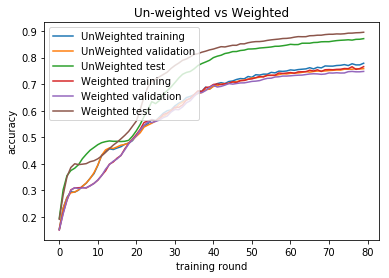

In [48]:
plt.plot(third['acc'])
plt.plot(third['val_acc'])
plt.plot(third['test_acc'])
plt.plot(thirdW['acc'])
plt.plot(thirdW['val_acc'])
plt.plot(thirdW['test_acc'])
plt.title('Un-weighted vs Weighted')
plt.ylabel('accuracy')
plt.xlabel('training round')
plt.legend(['UnWeighted training', 
            'UnWeighted validation',
            'UnWeighted test',
            'Weighted training', 
            'Weighted validation',
            'Weighted test'], 
           loc='upper left')
plt.show()

The difference again increases with more variance. Now we can see a clear advantage for the weighted model shortly after the 10th epoch. This increase in *efficiency* should be reflected on the loss function.

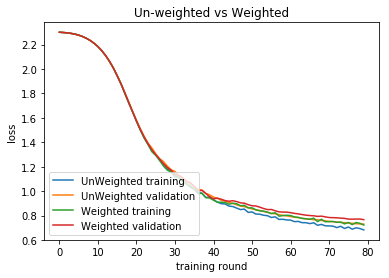

In [49]:
plt.plot(third['loss'])
plt.plot(third['val_loss'])
plt.plot(thirdW['loss'])
plt.plot(thirdW['val_loss'])
plt.title('Un-weighted vs Weighted')
plt.ylabel('loss')
plt.xlabel('training round')
plt.legend(['UnWeighted training', 'UnWeighted validation','Weighted training', 'Weighted validation'], 
           loc='lower left')
plt.show()

In [50]:
slope(third['val_loss'])

-0.021794398864744647

In [51]:
slope(thirdW['val_loss'])

-0.02116952016657872

## Depth 4

In [52]:
np.random.seed(seed)

fourth = simpleModelResult(
        x = X_trainS, y = Y_train,
        sample_weight=None,
        layers = 4, epochs = epochs,
        xv = X_validS, yv = Y_valid,
        xt = X_test, yt = Y_test,
        batchSize = batchSize)

np.random.seed(seed)
    
fourthW = simpleModelResult(
        x = X_trainS, y = Y_train,
        sample_weight=bdmsPar,
        layers = 4, epochs = epochs,
        xv = X_validS, yv = Y_valid,
        xt = X_test, yt = Y_test,
        batchSize = batchSize)

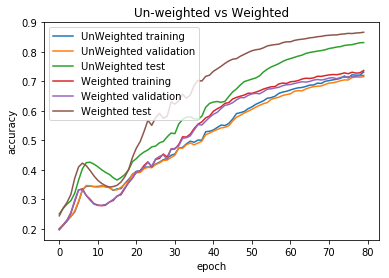

In [53]:
plt.plot(fourth['acc'])
plt.plot(fourth['val_acc'])
plt.plot(fourth['test_acc'])
plt.plot(fourthW['acc'])
plt.plot(fourthW['val_acc'])
plt.plot(fourthW['test_acc'])
plt.title('Un-weighted vs Weighted')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['UnWeighted training', 
            'UnWeighted validation',
            'UnWeighted test',
            'Weighted training', 
            'Weighted validation',
            'Weighted test'], 
           loc='upper left')
plt.show()

The advantage of accuracy in the test set agains increases on with the weighted model after the 10th epoch.

### Loss

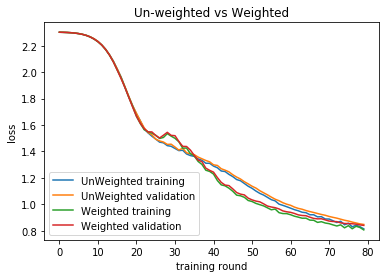

In [54]:
plt.plot(fourth['loss'])
plt.plot(fourth['val_loss'])
plt.plot(fourthW['loss'])
plt.plot(fourthW['val_loss'])
plt.title('Un-weighted vs Weighted')
plt.ylabel('loss')
plt.xlabel('training round')
plt.legend(['UnWeighted training', 'UnWeighted validation','Weighted training', 'Weighted validation'], 
           loc='lower left')
plt.show()

The speed in convergence now becomes greater.

In [55]:
slope(fourth['val_loss'])

-0.01997192670980326

In [56]:
slope(fourthW['val_loss'])

-0.02083489112405875

## Depth 6

To speed up this experiment, we further increase the variance of the model but now by adding **two** ReLU layers.

In [57]:
np.random.seed(seed)

sixth = simpleModelResult(
        x = X_trainS, y = Y_train,
        sample_weight=None,
        layers = 6, epochs = epochs,
        xv = X_validS, yv = Y_valid,
        xt = X_test, yt = Y_test,
        batchSize = batchSize)

np.random.seed(seed)
    
sixthW = simpleModelResult(
        x = X_trainS, y = Y_train,
        sample_weight=bdmsPar,
        layers = 6, epochs = epochs,
        xv = X_validS, yv = Y_valid,
        xt = X_test, yt = Y_test,
        batchSize = batchSize)

In [58]:
sixth.keys()

dict_keys(['acc', 'loss', 'test_acc', 'test_loss', 'val_acc', 'val_loss'])

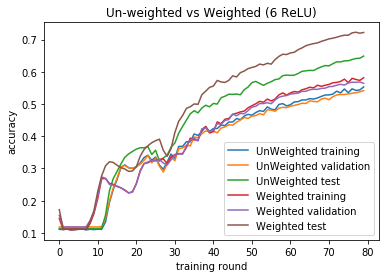

In [217]:
plt.plot(sixth['acc'])
plt.plot(sixth['val_acc'])
plt.plot(sixth['test_acc'])
plt.plot(sixthW['acc'])
plt.plot(sixthW['val_acc'])
plt.plot(sixthW['test_acc'])
plt.title('Un-weighted vs Weighted (6 ReLU)')
plt.ylabel('accuracy')
plt.xlabel('training round')
plt.legend(['UnWeighted training', 
            'UnWeighted validation',
            'UnWeighted test',
            'Weighted training', 
            'Weighted validation',
            'Weighted test'], 
           loc='lower right')
plt.show()

With so much variance, the accuracy now becomes less linear/predictable. However, I think that the trend of the weighted model having better accuracy keeps being clear. The faster convergence of the weighted model will be more evident with the loss function.

### Loss

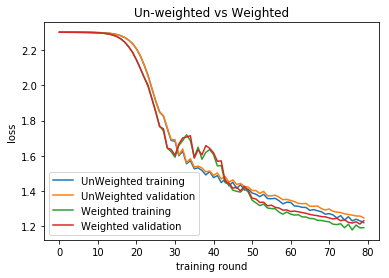

In [60]:
plt.plot(sixth['loss'])
plt.plot(sixth['val_loss'])
plt.plot(sixthW['loss'])
plt.plot(sixthW['val_loss'])
plt.title('Un-weighted vs Weighted')
plt.ylabel('loss')
plt.xlabel('training round')
plt.legend(['UnWeighted training', 'UnWeighted validation','Weighted training', 'Weighted validation'], 
           loc='lower left')
plt.show()

In [61]:
slope(sixth['val_loss'])

-0.016481926859688217

In [62]:
slope(sixthW['val_loss'])

-0.017045336085104317

# Higher variance models

The next two models, with 8 and 10 ReLU layers respectively, exhibit an even greater, I dare say, *chaotic* behaviour. I will train the last model for 100 epochs to show the general behaviour of the model. The general trend of the weighted model showing increasingly better accuracy compared to the unweighted one continues. 

## Depth 8

In [63]:
np.random.seed(seed)

eigth = simpleModelResult(
        x = X_trainS, y = Y_train,
        sample_weight=None,
        layers = 8, epochs = epochs,
        xv = X_validS, yv = Y_valid,
        xt = X_test, yt = Y_test,
        batchSize = batchSize)

np.random.seed(seed)
    
eigthW = simpleModelResult(
        x = X_trainS, y = Y_train,
        sample_weight=bdmsPar,
        layers = 8, epochs = epochs,
        xv = X_validS, yv = Y_valid,
        xt = X_test, yt = Y_test,
        batchSize = batchSize)

In [64]:
np.array_equal(X_test, X_validS)

False

In [65]:
X_test.shape

(10000, 28, 28)

In [66]:
X_validS.shape

(12000, 28, 28)

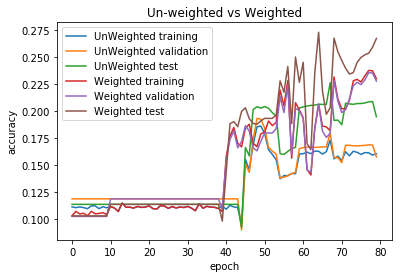

In [67]:
plt.plot(eigth['acc'])
plt.plot(eigth['val_acc'])
plt.plot(eigth['test_acc'])
plt.plot(eigthW['acc'])
plt.plot(eigthW['val_acc'])
plt.plot(eigthW['test_acc'])
plt.title('Un-weighted vs Weighted')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['UnWeighted training', 
            'UnWeighted validation',
            'UnWeighted test',
            'Weighted training', 
            'Weighted validation',
            'Weighted test'], 
           loc='upper left')
plt.show()

### Loss

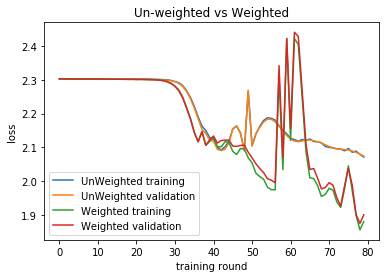

In [68]:
plt.plot(eigth['loss'])
plt.plot(eigth['val_loss'])
plt.plot(eigthW['loss'])
plt.plot(eigthW['val_loss'])
plt.title('Un-weighted vs Weighted')
plt.ylabel('loss')
plt.xlabel('training round')
plt.legend(['UnWeighted training', 'UnWeighted validation','Weighted training', 'Weighted validation'], 
           loc='lower left')
plt.show()

In [69]:
slope(eigth['val_loss'])

-0.0034405131090840617

In [70]:
slope(eigthW['val_loss'])

-0.004646935314054627

## Depth 10

In [71]:
epochs = 100

In [72]:
np.random.seed(seed)

tenth = simpleModelResult(
        x = X_trainS, y = Y_train,
        sample_weight=None,
        layers = 10, epochs = epochs,
        xv = X_validS, yv = Y_valid,
        xt = X_test, yt = Y_test,
        batchSize = batchSize)

np.random.seed(seed)
    
tenthW = simpleModelResult(
        x = X_trainS, y = Y_train,
        sample_weight=bdmsPar,
        layers = 10, epochs = epochs,
        xv = X_validS, yv = Y_valid,
        xt = X_test, yt = Y_test,
        batchSize = batchSize)

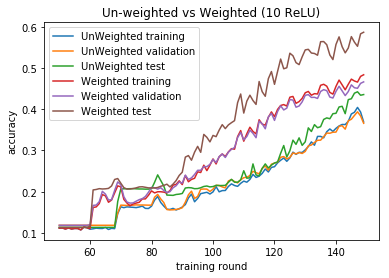

In [216]:
plt.plot(np.array(range(50,150)), tenth['acc'][49:149])
plt.plot(np.array(range(50,150)),tenth['val_acc'][49:149])
plt.plot(np.array(range(50,150)),tenth['test_acc'][49:149])
plt.plot(np.array(range(50,150)),tenthW['acc'][49:149])
plt.plot(np.array(range(50,150)),tenthW['val_acc'][49:149])
plt.plot(np.array(range(50,150)),tenthW['test_acc'][49:149])
plt.title('Un-weighted vs Weighted (10 ReLU)')
plt.ylabel('accuracy')
plt.xlabel('training round')
plt.legend(['UnWeighted training', 
            'UnWeighted validation',
            'UnWeighted test',
            'Weighted training', 
            'Weighted validation',
            'Weighted test'], 
           loc='upper left')
plt.show()

In [211]:
np.array(range(50,150)).size

100

### Loss

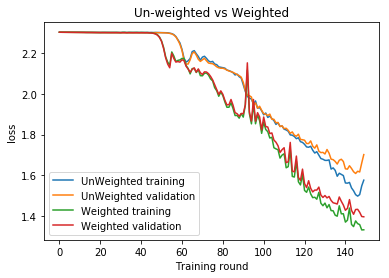

In [215]:
plt.plot(tenth['loss'][0:150])
plt.plot(tenth['val_loss'][0:150])
plt.plot(tenthW['loss'][0:150])
plt.plot(tenthW['val_loss'][0:150])
plt.title('Un-weighted vs Weighted')
plt.ylabel('loss')
plt.xlabel('Training round')
plt.legend(['UnWeighted training', 'UnWeighted validation','Weighted training', 'Weighted validation'], 
           loc='lower left')
plt.show()

In [75]:
slope(tenth['val_loss'])

-0.005802325123165325

In [76]:
slope(tenthW['val_loss'])

-0.0064711514228231685

# Analisis and Conclusions

The main aim of the weigthed approximation to the algorithmic regularization is to *steer* the optimization of a deep network towards samples of low algorithmic complexity. On the version used in the previous series of experiments, we separated the BDM of the samples in 3 categoriess: the top 75 percent, the top 50 percent and the rest, giving highest weights to the samples within the lower 50% and the lowest weight to the samples within the top 75% BDM. With this strategy, we hoped that the network would fit on the features of the samples with lower BDM, which AIT tell us tthey are the ones with lower ammount of random or incidental information.

The theory says that the stated effect would be greater on models with higher variance, given that these kind of models have an increased ability to fit towards the information contained in the training set, yet the statistical information that *regular* AIT optimization algorithms are able to capture cannot distinguish between structured and incidental information.

The results of the experiment validate this hypothesis: the training set contains a number of salted or corrupted samples of the MNIST database, which the AIT assign higher algorithmic information content. By  using the weigthed approximation to the algorithmic regularization we are able to increase the accuracy of the model, therefore controlling over-fitting towards random information and **converge faster** towards the optimum value, all this in function of the variance of the model in question. With higher variance, the bigger the difference in accuracy between the weighted and unweighted models, and the faster the weighted model will converge towards the minimum of the loss function.

For instance, as the next plot shows, the slope of the linear approximation to the loss function show a stepper gradient for the weigthed models in comparison to the unweigthed ones for the first 20 epochs.

In [95]:
unweightS = np.array([slope(first['val_loss']),
 slope(second['val_loss'][0:20]),
 slope(third['val_loss'][0:20]),
 slope(fourth['val_loss'][0:20]),
 slope(sixth['val_loss'][0:20]),
 slope(eigth['val_loss'][0:20]),
 slope(tenth['val_loss'][0:20]) ])

In [96]:
weightS = np.array([slope(firstW['val_loss']),
 slope(secondW['val_loss'][0:20]),
 slope(thirdW['val_loss'][0:20]),
 slope(fourthW['val_loss'][0:20]),
 slope(sixthW['val_loss'][0:20]),
 slope(eigthW['val_loss'][0:20]),
 slope(tenthW['val_loss'][0:20]) ])

In [79]:
tenth['val_loss'][0:20]

array([2.30255057, 2.3024924 , 2.30243453, 2.30237165, 2.30230556,
       2.30223616, 2.30216239, 2.3020875 , 2.30200946, 2.30192865,
       2.30184503, 2.30175725, 2.30167025, 2.30157685, 2.30148422,
       2.30138461, 2.30128377, 2.30118139, 2.30108164, 2.30098155])

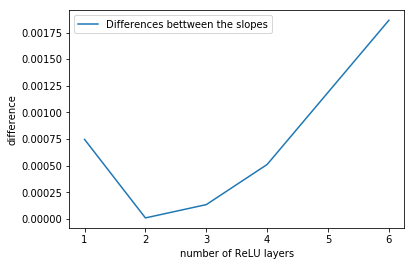

In [218]:
plt.plot(np.array([1,2,3,4,6]),np.abs(unweightS-weightS)[0:5])
plt.ylabel('difference')
plt.xlabel('number of ReLU layers')
plt.legend(['Differences bettween the slopes'], 
           loc='upper left')
plt.show()

The fact that the weighted and unweighted models seem to converge at the 100th epoch of the 10th experiment is not surprissing, given that, the weighted approximation to the algorithmic regularization is a multiplicative penalty, therefore minimizing the regular function will also minimize the weighted one.

### Acccuracy graph

In [104]:
from scipy.integrate import simps

In [ ]:
trapz(slope(first['val_loss'], dx=1)

In [107]:
acs = np.array([
    simps(first['acc'], dx=1),
    simps(second['acc'], dx=1),
    simps(third['acc'], dx=1),
    simps(fourth['acc'], dx=1),
    simps(sixth['acc'], dx=1),
    simps(eigth['acc'], dx=1),
    simps(tenth['acc'], dx=1)]
         )

In [108]:
acs

array([57.47561806, 54.74641667, 49.00078819, 41.05540972, 30.00928819,
       10.41100694, 53.06965625])

In [109]:
acsW = np.array([
    simps(firstW['acc'], dx=1),
    simps(secondW['acc'], dx=1),
    simps(thirdW['acc'], dx=1),
    simps(fourthW['acc'], dx=1),
    simps(sixthW['acc'], dx=1),
    simps(eigthW['acc'], dx=1),
    simps(tenthW['acc'], dx=1)]
         )

In [110]:
acsW

array([55.69113542, 52.94894097, 48.11691667, 42.47295486, 31.15853125,
       12.00857639, 60.60058333])

In [111]:
first['acc']

array([0.19095833, 0.28425   , 0.36833333, 0.43716667, 0.47970833,
       0.52045833, 0.54829167, 0.56695833, 0.58229167, 0.602125  ,
       0.61841667, 0.63320833, 0.6445    , 0.66170833, 0.6645    ,
       0.677375  , 0.679875  , 0.69141667, 0.69720833, 0.699625  ,
       0.70766667, 0.71375   , 0.71704167, 0.718     , 0.72304167,
       0.727375  , 0.727625  , 0.73795833, 0.73725   , 0.74066667,
       0.74358333, 0.74616667, 0.74954167, 0.755     , 0.75404167,
       0.75825   , 0.76179167, 0.76083333, 0.76854167, 0.76483333,
       0.76683333, 0.7755    , 0.77504167, 0.7745    , 0.77558333,
       0.780125  , 0.78133333, 0.78308333, 0.78175   , 0.790875  ,
       0.78691667, 0.79079167, 0.79304167, 0.79004167, 0.793625  ,
       0.79608333, 0.79508333, 0.79929167, 0.79520833, 0.80320833,
       0.80016667, 0.80225   , 0.80454167, 0.80341667, 0.80233333,
       0.80845833, 0.804     , 0.810625  , 0.80566667, 0.811625  ,
       0.81079167, 0.809875  , 0.811     , 0.81316667, 0.81487

In [142]:
acsM = np.array([
    np.mean(first['acc']),
    np.mean(second['acc']),
    np.mean(third['acc']),
    np.mean(fourth['acc']),
    np.mean(sixth['acc']),
    np.mean(eigth['acc']),
    np.mean(tenth['acc'])]
         )

In [143]:
acs

array([0.72465781, 0.69019583, 0.6182599 , 0.51901667, 0.37927656,
       0.13183646, 0.26706521])

In [144]:
acsWM = np.array([
    np.mean(firstW['acc']),
    np.mean(secondW['acc']),
    np.mean(thirdW['acc']),
    np.mean(fourthW['acc']),
    np.mean(sixthW['acc']),
    np.mean(eigthW['acc']),
    np.mean(tenthW['acc'])]
         )

In [145]:
testAM = np.array([
    np.mean(first['test_acc']),
    np.mean(second['test_acc']),
    np.mean(third['test_acc']),
    np.mean(fourth['test_acc']),
    np.mean(sixth['test_acc']),
    np.mean(eigth['test_acc']),
    np.mean(tenth['test_acc'])]
         )

In [146]:
testA

array([0.81537625, 0.771225  , 0.7016025 , 0.6014725 , 0.43880125,
       0.14900125, 0.299423  ])

In [147]:
testAWM = np.array([
    np.mean(firstW['test_acc']),
    np.mean(secondW['test_acc']),
    np.mean(thirdW['test_acc']),
    np.mean(fourthW['test_acc']),
    np.mean(sixthW['test_acc']),
    np.mean(eigthW['test_acc']),
    np.mean(tenthW['test_acc'])]
         )

In [148]:
testAW

array([0.813345  , 0.77486125, 0.72696125, 0.65571375, 0.48504625,
       0.1640075 , 0.35987   ])

In [149]:
valAM = np.array([
    np.mean(first['val_acc']),
    np.mean(second['val_acc']),
    np.mean(third['val_acc']),
    np.mean(fourth['val_acc']),
    np.mean(sixth['val_acc']),
    np.mean(eigth['val_acc']),
    np.mean(tenth['val_acc'])]
         )

In [122]:
valAWM = np.array([
    np.mean(firstW['val_acc']),
    np.mean(secondW['val_acc']),
    np.mean(thirdW['val_acc']),
    np.mean(fourthW['val_acc']),
    np.mean(sixthW['val_acc']),
    np.mean(eigthW['val_acc']),
    np.mean(tenthW['val_acc'])]
         )

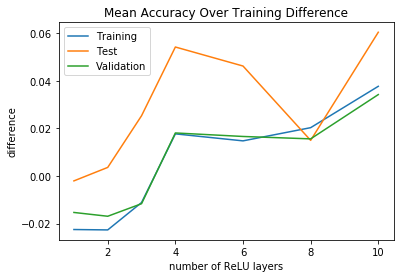

In [219]:
plt.plot(np.array([1,2,3,4,6,8,10][0:7]),(acsW-acs)[0:7])
plt.plot(np.array([1,2,3,4,6,8,10][0:7]),(testAW-testA)[0:7])
plt.plot(np.array([1,2,3,4,6,8,10][0:7]),(valAW-valA)[0:7])
plt.ylabel('difference')
plt.xlabel('number of ReLU layers')
plt.legend(['Training', 'Test','Validation'], 
           loc='upper left')
plt.title('Mean Accuracy Over Training Difference')

# Display the figure.
plt.show()

In [154]:
acsMMax = np.array([
    np.max(first['acc']),
    np.max(second['acc']),
    np.max(third['acc']),
    np.max(fourth['acc']),
    np.max(sixth['acc']),
    np.max(eigth['acc']),
    np.max(tenth['acc'])]
         )

In [155]:
acsMMaxW = np.array([
    np.max(firstW['acc']),
    np.max(secondW['acc']),
    np.max(thirdW['acc']),
    np.max(fourthW['acc']),
    np.max(sixthW['acc']),
    np.max(eigthW['acc']),
    np.max(tenthW['acc'])]
         )

In [193]:
testAMax = np.array([
    np.max(first['test_acc']),
    np.max(second['test_acc']),
    np.max(third['test_acc']),
    np.max(fourth['test_acc']),
    np.max(sixth['test_acc']),
    np.max(eigth['test_acc']),
    np.max(tenth['test_acc'][0:149])]
         )

In [194]:
testAMax

array([0.8958, 0.8935, 0.8715, 0.8319, 0.6488, 0.2261, 0.4423])

In [195]:
testAMaxW = np.array([
    np.max(firstW['test_acc']),
    np.max(secondW['test_acc']),
    np.max(thirdW['test_acc']),
    np.max(fourthW['test_acc']),
    np.max(sixthW['test_acc']),
    np.max(eigthW['test_acc']),
    np.max(tenthW['test_acc'][0:149])]
         )

In [196]:
testAMaxW

array([0.9019, 0.9072, 0.8956, 0.8669, 0.7228, 0.2728, 0.5867])

In [197]:
valAMMax = np.array([
    np.max(first['val_acc']),
    np.max(second['val_acc']),
    np.max(third['val_acc']),
    np.max(fourth['val_acc']),
    np.max(sixth['val_acc']),
    np.max(eigth['val_acc']),
    np.max(tenth['val_acc'][0:149])]
         )

In [198]:
valAMMaxW = np.array([
    np.max(firstW['val_acc']),
    np.max(secondW['val_acc']),
    np.max(thirdW['val_acc']),
    np.max(fourthW['val_acc']),
    np.max(sixthW['val_acc']),
    np.max(eigthW['val_acc']),
    np.max(tenthW['val_acc'][0:149])]
         )

In [199]:
testAMaxW-testAMax

array([0.0061, 0.0137, 0.0241, 0.035 , 0.074 , 0.0467, 0.1444])

In [200]:
testAMaxW

array([0.9019, 0.9072, 0.8956, 0.8669, 0.7228, 0.2728, 0.5867])

In [201]:
testAMax

array([0.8958, 0.8935, 0.8715, 0.8319, 0.6488, 0.2261, 0.4423])

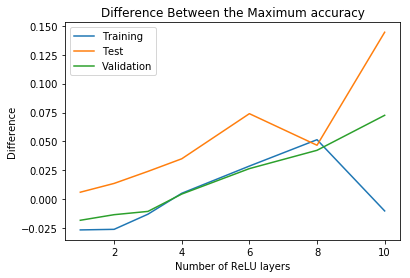

In [205]:
plt.plot(np.array([1,2,3,4,6,8,10][0:7]),(acsMMaxW-acsMMax)[0:7])
plt.plot(np.array([1,2,3,4,6,8,10][0:7]),(testAMaxW-testAMax)[0:7])
plt.plot(np.array([1,2,3,4,6,8,10][0:7]),(valAMMaxW-valAMMax)[0:7])
plt.ylabel('Difference')
plt.xlabel('Number of ReLU layers')
plt.legend(['Training', 'Test','Validation'], 
           loc='upper left')
plt.title('Difference Between the Maximum accuracy')

# Display the figure.
plt.show()